In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
import joblib as jb
from glob import glob
from lightgbm import LGBMRegressor
import colorsys
from preprocessing import *

In [6]:
path_bat = '/home/vinicius/Área de Trabalho/Faculdade/TCC/data/DADOS_TCC_BIANCA/02.Dados_Processados/02.XYZ/BATIMETRIA_PROCESSADA_BABITONGA_2018_DHN_WGS84_UTM22S.xyz'

In [7]:
rhos_list = [e for e in glob('../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/*.tif') if 'rhos' in str(e)]

In [8]:
rhos_list

['../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_740.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_704.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_665.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_492.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_560.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_783.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_833.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_443.tif']

In [12]:
bands_name = ['b6', 'b5', 'b4', 'b2', 'b3','b7', 'b8', 'b1']

In [10]:
tiff_dict = dict()
for i, path in enumerate(rhos_list):
    tiff_dict[f'{bands_name[i]}'] = tifffile.TiffFile(path).asarray()

In [14]:
#jb.dump(tiff_dict, 'output_data/tiff_dict.pkl.z')
tiff_dict = jb.load('output_data/tiff_dict.pkl.z')

In [15]:
df = pd.read_csv(path_bat, sep=' ', header=None)
df.columns = ['x', 'y', 'z']
df.head(2)

,x,y,z
0,720507.82,7089857.17,1.96
1,720507.95,7089857.15,1.98


In [ ]:
ndwib3b8 = ndwi(tiff_dict['b3'], tiff_dict['b8'])

In [18]:
#jb.dump(ndwib3b8, 'output_data/ndwib3b8.pkl.z')
ndwib3b8 = jb.load('output_data/ndwib3b8.pkl.z')

In [20]:
wf_th = 0.3
ndwib3b8 = (ndwib3b8[:,:] > wf_th)
ndwib3b8

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True]])

In [16]:
water_filter = ndwib3b8.astype(np.uint8) * 255

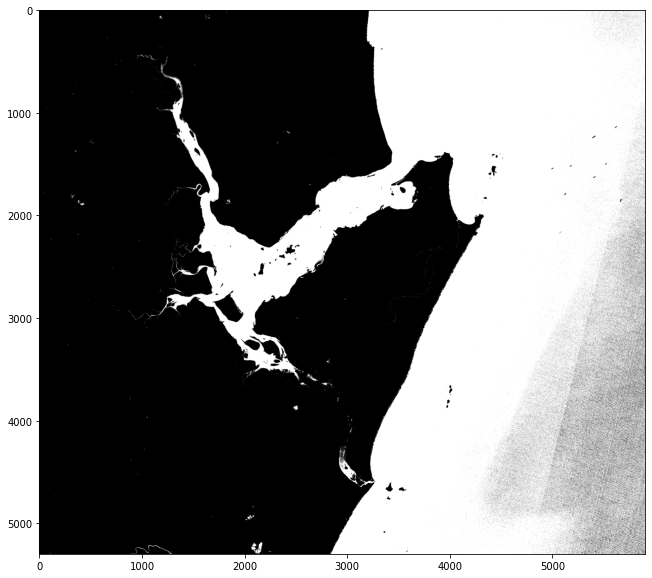

In [11]:
plt.figure(figsize=(12,10))
plt.imshow(water_filter, "gray")

In [21]:
bgr_image = np.dstack((tiff_dict['b2'],tiff_dict['b3'],tiff_dict['b4']))
bgr_image = bgr_image + 0.1
bgr_image = bgr_image.clip(0,1)

In [22]:
bgr_image = (bgr_image*255.99).astype(np.uint8)

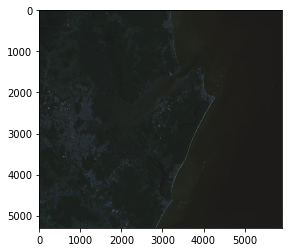

In [23]:
plt.imshow(bgr_image)

In [24]:
b7fix = tiff_dict['b7'].shape[0]/float(tiff_dict['b1'].shape[0])
b7fix

0.6647791619479049

In [25]:
from tqdm.notebook import tqdm

aux = list()
for i in tqdm(range(bgr_image.shape[0])):
    for j in range(bgr_image.shape[1]):
        if ndwib3b8[i][j]:
            aux.append(np.array([j,i, tiff_dict['b6'][i][j], tiff_dict['b5'][i][j], tiff_dict['b4'][i][j], 
                                 tiff_dict['b2'][i][j], tiff_dict['b3'][i][j], tiff_dict['b7'][int(np.clip(i*b7fix,0, tiff_dict['b7'].shape[0]))][j],tiff_dict['b8'][i][j], tiff_dict['b1'][i][j]]))

In [29]:
hf = h5py.File('output_data/array_allpixels_allbands.h5', 'w')

In [30]:
hf.create_dataset('dataset_1', data=aux)

<HDF5 dataset "dataset_1": shape (13395599, 10), type "<f8">

In [41]:
hf.close()

In [32]:
columns = ['px', 'py'] + bands_name

In [33]:
del aux #clean memory

In [34]:
import pandas as pd

In [57]:
hf = h5py.File('output_data/array_allpixels_allbands.h5', 'r')
aux = np.array(hf.get('dataset_1'))
hf.close()

In [61]:
df_all = pd.DataFrame(aux)

In [63]:
df_all.columns = columns

In [66]:
lgbm = jb.load('models/lgbm_baseline.pkl.z')

In [67]:
z = lgbm.predict(df_all.drop(["px","py"],axis=1))

In [69]:
hf = h5py.File('output_data/predictions_baseline.h5', 'w')
hf.create_dataset('dataset_pred', data=z)
hf.close()

In [76]:
df_all['z'] = z

In [77]:
output = bgr_image.copy()
for i, row in tqdm(enumerate(df_all.itertuples())):
    x = int(row[1])
    y = int(row[2])
    z = row[11]
    output[y][x] = [int(e*255) for e in (colorsys.hls_to_rgb(z/40, 0.5, 1))]

In [80]:
import cv2
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)

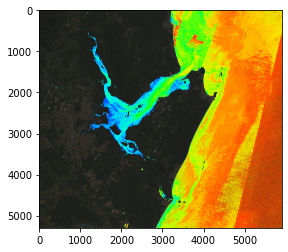

In [93]:
plt.imshow(output)

In [96]:
cv2.imwrite("photos/predict_baseline_result.png", output)

True

In [127]:
output = cv2.imread('photos/predict_baseline_result.png')

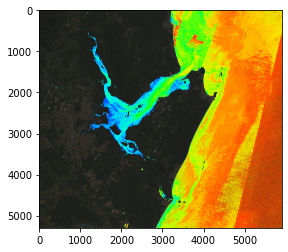

In [128]:
plt.imshow(output)